In [1]:
import argparse
import os
import sys
import numpy as np

import torch
import matplotlib.pyplot as plt     # type: ignore

things_stim_path = '/user_data/mmhender/stimuli/things/'
save_stim_path = '/user_data/mmhender/stimuli/featsynth/images_v1'
texture_synth_root = os.path.dirname(os.getcwd())

sys.path.append(os.path.join(texture_synth_root,'code'))

import utilities
import model_spatial
import optimize
import pandas as pd
import PIL
import time

import things_utils
import segmentation_utils

/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
things_stim_path = '/user_data/mmhender/stimuli/things/'


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

concepts_filename = os.path.join(things_stim_path, 'concepts_use.npy')
concepts_use = np.load(concepts_filename,allow_pickle=True).item()
categ_names = concepts_use['categ_names']
concept_names_subsample = concepts_use['concept_names_subsample']
image_names = concepts_use['image_names']
concept_ids_subsample = concepts_use['concept_ids_subsample']
n_categ = len(categ_names)
n_conc_each = len(concept_names_subsample[0])

categ_process = np.arange(n_categ)
conc_process = np.arange(n_conc_each)
n_ims_do = 10
ims_process = np.arange(n_ims_do)

cpu


In [3]:
ca = 0; categ_ind = categ_process[ca]
categ = categ_names[categ_ind]

co = 0; conc_ind = conc_process[co]
conc = concept_names_subsample[categ_ind][conc_ind]

ii=0;

target_image_filename = things_utils.get_filename(categ, conc, ii)
    
print('\nCATEG %d of %d, IMAGE %d\n'%(ca, len(categ_process), ii))
print('processing target image %s'%target_image_filename)

name = target_image_filename.split('/')[-1].split('.jpg')[0]

model_path = os.path.join(texture_synth_root, 'models','VGG19_normalized_avg_pool_pytorch')

# args.lr = 1.0
# args.max_iter = 20
# args.checkpoint_every = 1
# if args.debug:
#     args.n_steps = 1
# args.rndseed = None

n_grid_eachside = 1
lr = 1.0
max_iter = 20
checkpoint_every = 1
debug=True
n_steps = 100
do_sqrt = True
which_grid=5
save_loss=True


CATEG 0 of 21, IMAGE 0

processing target image /user_data/mmhender/stimuli/things/Images/toucan/toucan_01b.jpg


In [4]:
layer_names_uppercase = ['Conv1','MaxPool1','MaxPool2','MaxPool3','MaxPool4']
n_layers = len(layer_names_uppercase)
overlap_each_layer = []
for ll in range(n_layers):

    fn = os.path.join(texture_synth_root,'grid_overlap','vgg19_gridoverlap_grid%d_%dx%d_%s.npy'%(which_grid,
                                                                           n_grid_eachside, 
                                                                    n_grid_eachside, 
                                                                    layer_names_uppercase[ll]))
    print('loading overlap from %s'%fn)
    overlap = np.load(fn)
    overlap_each_layer.append(overlap)

loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_Conv1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool1.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool2.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool3.npy
loading overlap from /user_data/mmhender/featsynth/texture_synthesis/grid_overlap/vgg19_gridoverlap_grid5_1x1_MaxPool4.npy


took 0.01063 s to preproc and save orig image


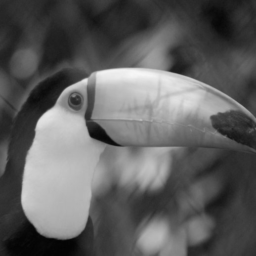

In [8]:
st = time.time()
# target_image_tosave = utilities.preprocess_image_tosave(utilities.load_image(target_image_filename))
target_image_tosave = utilities.preprocess_image_tosave_grayscale(utilities.load_image(target_image_filename))
# filename_save = os.path.join(out_dir, 'orig.png')
# print('saving image to %s'%filename_save)
# target_image_tosave.save(filename_save)
elapsed = time.time() - st
print('took %.5f s to preproc and save orig image'%elapsed)
target_image_tosave

took 0.01049 s to preproc and save orig image


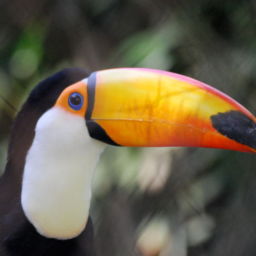

In [6]:
st = time.time()
target_image_tosave = utilities.preprocess_image_tosave(utilities.load_image(target_image_filename))
# target_image_tosave = utilities.preprocess_image_tosave_grayscale(utilities.load_image(target_image_filename))
# filename_save = os.path.join(out_dir, 'orig.png')
# print('saving image to %s'%filename_save)
# target_image_tosave.save(filename_save)
elapsed = time.time() - st
print('took %.5f s to preproc and save orig image'%elapsed)
target_image_tosave

In [9]:
st = time.time()
# load target image to use in synthesis (different preproc than above)
target_image = utilities.preprocess_image_grayscale(
    utilities.load_image(target_image_filename)
)
elapsed = time.time() - st
print('took %.5f s to preproc image for synthesis'%elapsed)


took 0.01928 s to preproc image for synthesis


In [27]:
st = time.time()
# load target image to use in synthesis (different preproc than above)
target_image = utilities.preprocess_image(
    utilities.load_image(target_image_filename)
)
elapsed = time.time() - st
print('took %.5f s to preproc image for synthesis'%elapsed)


took 0.02707 s to preproc image for synthesis


In [28]:
target_image[0,:,120,120]

tensor([-102.9390,    0.2210,   82.3200])

In [29]:
import types
args = types.SimpleNamespace()
args.lr = 1.0
args.max_iter = 20
args.checkpoint_every = 1
args.n_steps = 1
args.rndseed = 431345

In [30]:
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']
layers_do = [1,2,3,4]
ll = 1

layers_match = important_layers[0:ll+1]
spatial_weights_use = overlap_each_layer[0:ll+1]
print('making texture for layers:')
print(layers_match)

st = time.time()
net = model_spatial.Model(model_path, device, target_image, \
                          important_layers=layers_match, \
                          spatial_weights_list = spatial_weights_use, 
                          do_sqrt = do_sqrt)

# synthesize
optimizer = optimize.Optimizer(net, args)
result = optimizer.optimize()
elapsed = time.time() - st
print('took %.5f s to run synthesis'%elapsed)

making texture for layers:
['relu1_1', 'pool1']
step: 1, loss: 74611216.0 (33.92s)
took 36.62417 s to run synthesis


In [25]:
net.net[0].weight.shape

torch.Size([64, 3, 3, 3])

In [17]:
final_image = utilities.postprocess_image(
                        result, utilities.load_image(target_image_filename).convert('L').convert('RGB'),
                    )

In [31]:
final_image2 = utilities.postprocess_image(
                        result, utilities.load_image(target_image_filename).convert('L').convert('RGB'),
                    )

In [20]:
result[0,:,100,100]

tensor([-55.1290, -26.9282, -20.0807])

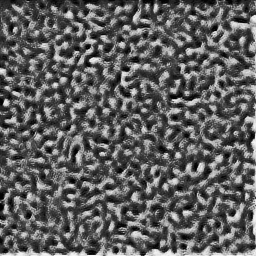

In [26]:
final_image.convert('L')

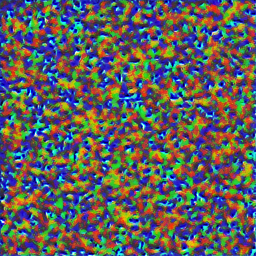

In [33]:
final_image2